we have:

    at q state
    po q state
    po m div
    po q div
    at q zip3
    at y zip3
    at y tract
    
at y state -> at y county -> at y tract    

or 

at y state -> at y zip3 -> at y zip5  

a zip code may be shared by two couties. a tract may have multiple zips.


po m div -> po q state -> at y state -> at y county -> at y tract

or 

po m div -> po q state -> at y state -> at y zip3 -> at y zip5



# state_monthly

In [1]:
%reset -f

In [2]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [3]:
def read_po_monthly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_monthly_hist.csv", parse_dates=['Month'])
    #df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    cols=[u for u in df.columns if 'NSA' in u] +['Month']
    df=df[cols]
    cols=[u.split('(')[0].strip() for u in df.columns]
    df.columns=cols
    df=df[['Month','Middle Atlantic','East North Central','West North Central', 'South Atlantic','Pacific']]
    df=df[df.Month>=pd.to_datetime('1991-1-1')]
    df=df.set_index('Month')
    df.columns=["MA",'ENC','WNC','SA','PAC']
    assert df.isnull().sum().sum()==0
    return df
def read_po_monthly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_monthly_hist_with_forecast.csv", parse_dates=[0])
    df.columns=['Month']+list(df.columns[1:])
    df=df[df['Month']<pd.to_datetime('2019-1-1')]
    df=df.set_index(['Month'])
    df=df[["MA",'ENC','WNC','SA','PAC']]
    assert df.isnull().sum().sum()==0
    return df

In [4]:
div_po_monthly=read_po_monthly_hpi()

In [5]:
div_po_monthly.tail()

MA         ENC         WNC          SA         PAC
Month                                                                 
2018-08-01  244.584604  224.448794  272.288133  275.515458  318.638901
2018-09-01  243.597944  226.374702  269.999277  275.880371  318.091299
2018-10-01  244.804319  226.315802  268.901616  277.947724  320.694880
2018-11-01  241.312560  225.968267  268.631761  279.515680  321.900547
2018-12-01  245.728476  225.981601  268.141916  277.845004  324.682659

In [6]:
div_po_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [7]:
def read_po_state_quarterly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_state.txt" ,sep="\t")
    df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    df['hpi']=df['index_nsa'].astype(np.float)
    df=df[df.yr>1990]
    df['Month']=pd.to_datetime(df.apply(lambda u: '{}-{}-{}'.format(u['yr'], (u['qtr']-1)*3+2,1),axis=1))
    df=df.drop(['index_nsa','index_sa','Warning'],axis=1)
    assert df.isnull().sum().sum()==0
    df=pd.pivot_table(df, columns='state',values='hpi', index=['Month'])
    df=df[["NY", "OH", "IA", "NC", "CA"]]
    return df
def read_po_state_quarterly_hpi():
    df=pd.read_csv("../input/third2/HPI_state_PO_quarterly_hist_with_forecast.csv", parse_dates=[0])
    df.columns=['Month']+list(df.columns[1:])
    df=df[df['Month']<pd.to_datetime('2019-1-1')]    
    df['Month']=df['Month'].map(lambda u: pd.to_datetime('{}-{}-1'.format(u.year,u.month+1)))
    df=df.set_index(['Month'])
    df=df[["NY", "OH", "IA", "NC", "CA"]]
    return df

In [8]:
state_po_quarterly=read_po_state_quarterly_hpi()

In [9]:
state_po_quarterly.index.max()

Timestamp('2018-11-01 00:00:00')

In [10]:
state_po_quarterly.tail()

NY          OH          IA          NC          CA
Month                                                                 
2017-11-01  239.010000  194.490000  239.460000  233.360000  272.130000
2018-02-01  239.580000  196.820000  239.880000  238.690000  277.870000
2018-05-01  243.261504  203.149872  245.401957  247.406250  281.136886
2018-08-01  250.373859  205.597159  245.978837  250.980454  285.062411
2018-11-01  247.733430  207.755245  249.588980  250.444830  290.674044

In [11]:
src=div_po_monthly.sort_index()
target=state_po_quarterly.sort_index()

In [12]:
dest=target[target.index<pd.to_datetime('1800-1-1')]
assert len(dest)==0
dest=dest.reindex(src.index)

In [13]:
col_map={'CA': 'PAC', 'IA': 'WNC', 'NC': 'SA', 'NY': 'MA', 'OH': 'ENC'}

In [14]:
from dateutil.relativedelta import relativedelta

In [15]:
def make_quarter(dt):
    assert dt.month in {2,5,8,11}
    return [dt - relativedelta(months=1),dt,dt + relativedelta(months=1)]

In [16]:
def make_src_ratio(src,dt):
    quarter_dts1=make_quarter(dt)
    quarter_dts2=make_quarter(dt-relativedelta(months=3))
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [17]:
make_quarter(target.index[0])

[Timestamp('1991-01-01 00:00:00'),
 Timestamp('1991-02-01 00:00:00'),
 Timestamp('1991-03-01 00:00:00')]

In [18]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        quarter_dts=make_quarter(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [19]:
dest=[]
for col in target.columns:
    target_s=target[col]
    src_s=src[col_map[col]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns,index=src.index)

NY MA


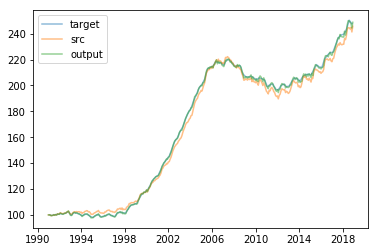

OH ENC


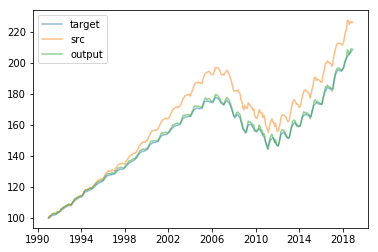

IA WNC


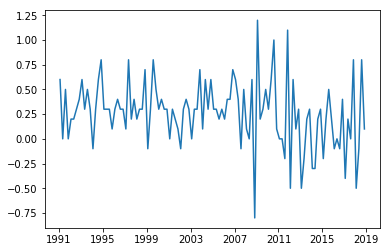

NC SA


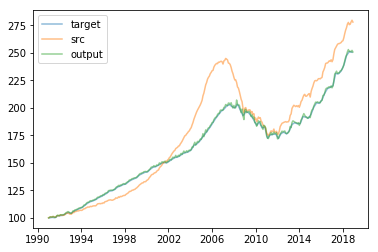

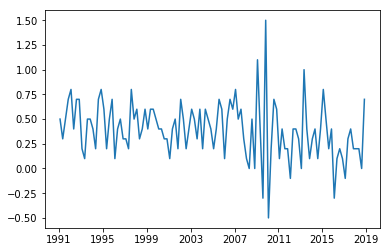

CA PAC


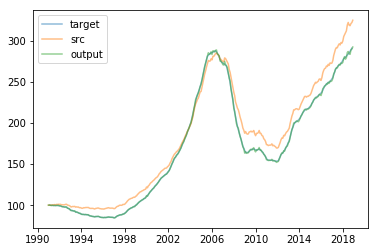

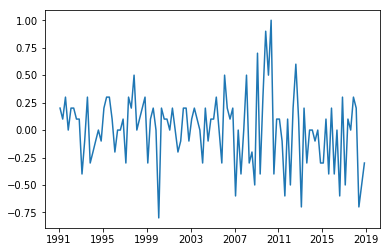

In [20]:
for i in range(len(dest.columns)):
    print dest.columns[i], src.columns[i]
    plt.plot(target.iloc[:,i],alpha=0.5)
    plt.plot(src.iloc[:,i],alpha=0.5)
    plt.plot(dest.iloc[:,i],alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(dest.iloc[:,i]/target.iloc[:,i]-1),1).dropna())
    plt.show()

In [21]:
dest.tail()

NY          OH          IA          NC          CA
Month                                                                 
2018-08-01  249.918980  205.107320  248.052295  251.029849  283.737456
2018-09-01  248.910801  206.867266  245.967165  251.362332  283.249834
2018-10-01  247.845010  208.946399  250.070775  250.776382  288.602463
2018-11-01  244.309881  208.625537  249.819818  252.191060  289.687478
2018-12-01  248.780646  208.637848  249.364276  250.683704  292.191179

In [22]:
dest.to_csv("../input/third2/HPI_po_state_monthly.csv")

# county monthly

In [23]:
%reset -f

In [24]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [25]:
state_po_monthly=pd.read_csv("../input/third2/HPI_po_state_monthly.csv", parse_dates=['Month']).set_index('Month')
print state_po_monthly.columns
state_po_monthly.columns=['36','39','19','37','06']

Index([u'NY', u'OH', u'IA', u'NC', u'CA'], dtype='object')


In [26]:
dict(zip ([u'NY', u'OH', u'IA', u'NC', u'CA'],['36','39','19','37','06']))

{u'CA': '06', u'IA': '19', u'NC': '37', u'NY': '36', u'OH': '39'}

In [27]:
state_po_monthly.head()

36          39          19          37          06
Month                                                                 
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000
1991-02-01  100.040000  101.000000  100.610000  100.520000  100.210000
1991-03-01   99.930000  101.350000  100.410000  100.970000  100.000000
1991-04-01   99.330001  101.730924  101.466203  100.888174   99.574089
1991-05-01   99.590001  102.350747  101.245012  100.748274   99.812685

In [28]:
state_po_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [29]:
county_at_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_county_5state.csv", dtype={'FIPS code':np.str}).set_index("FIPS code").T
county_at_hpi.index=pd.to_datetime(['{}-07-01'.format(u) for u in county_at_hpi.index])

In [30]:
county_at_hpi.index.max()

Timestamp('2018-07-01 00:00:00')

In [31]:
county_at_hpi.tail()

FIPS code        06001       06003       06005       06007       06009  \
2014-07-01  1241.38000  174.110000  245.880000  607.450000  255.390000   
2015-07-01  1349.54000  152.000000  268.500000  629.420000  277.030000   
2016-07-01  1500.75000  158.890000  294.620000  673.290000  300.470000   
2017-07-01  1626.37000  170.853470  317.730000  719.960000  328.340000   
2018-07-01  1751.98999  182.816916  340.840027  766.630066  356.209991   

FIPS code        06011        06013       06015       06017       06019  \
2014-07-01  246.220000   935.220000  325.630000  688.830000  535.740000   
2015-07-01  260.730000   995.460000  337.610000  722.400000  562.770000   
2016-07-01  281.290000  1096.170000  363.640000  780.160000  594.510000   
2017-07-01  299.300000  1197.700000  392.770000  843.650000  646.830000   
2018-07-01  317.309967  1299.229858  421.899963  907.140076  699.150024   

FIPS code      ...           39157       39159       39161       39163  \
2014-07-01     ...      281.740000  359.210000  180.770000  130.500000   
2015-07-01     ...      288.450000  377.020000  192.110000  132.598340   
2016-07-01     ...      299.630000  394.960000  187.810000  135.450000   
2017-07-01     ...      310.470000  418.080000  192.920000  127.090000   
2018-07-01     ...      321.309998  441.199982  198.029999  118.729996   

FIPS code        39165   39167      39169       39171       39173       39175  
2014-07-01  319.200000  222.51  304.00000  173.870000  257.030000  199.020000  
2015-07-01  331.260000  234.73  324.19000  179.590000  262.990000  204.170000  
2016-07-01  342.600000  239.06  332.05000  185.260000  271.570000  211.520000  
2017-07-01  363.650000  243.03  350.16000  188.720000  281.090000  223.490000  
2018-07-01  384.699982  247.00  368.27002  192.180008  290.609985  235.460007  

[5 rows x 402 columns]

In [32]:
src=state_po_monthly.sort_index()
target=county_at_hpi.sort_index()

In [33]:
from dateutil.relativedelta import relativedelta

In [34]:
def make_year(yr):
    return pd.to_datetime(['{}-{}-01'.format(yr,m) for m in range(1,13)])

In [35]:
def make_src_ratio(src,yr):
    quarter_dts1=make_year(yr)
    quarter_dts2=make_year(yr-1)
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [36]:
make_year(target.index[0].year)

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01', '1991-11-01', '1991-12-01'],
              dtype='datetime64[ns]', freq=None)

In [37]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        dt=dt.year
        quarter_dts=make_year(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [38]:
len(target.columns)

402

In [39]:
dest=[]
for col in target.columns[:]:
    target_s=target[col]
    src_s=src[col[:2]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns[:len(dest)],index=src.index)

43 06087


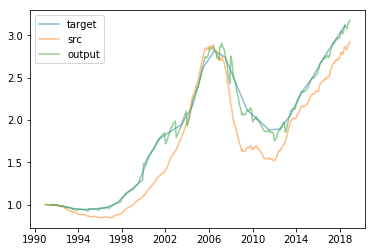

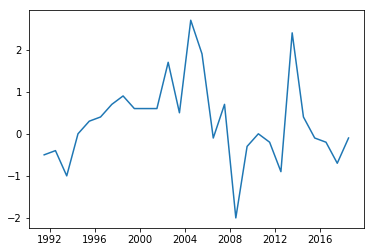

49 06101


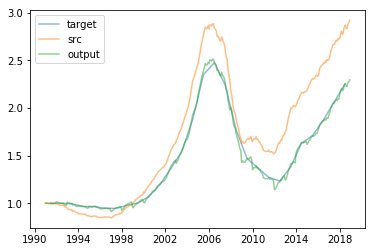

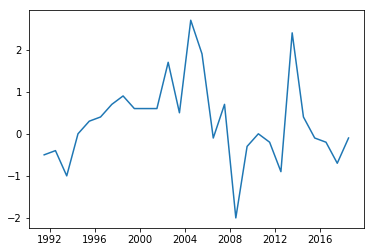

232 37033


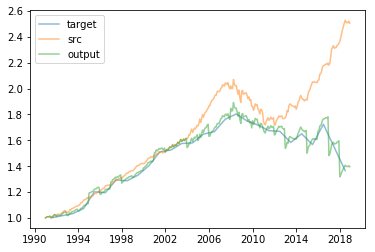

301 37173


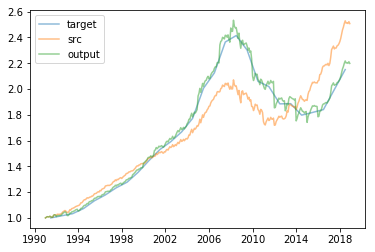

213 36119


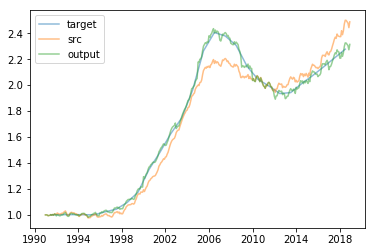

95 19079


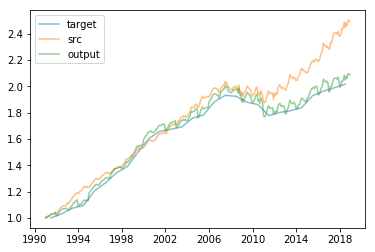

345 39063


168 36029


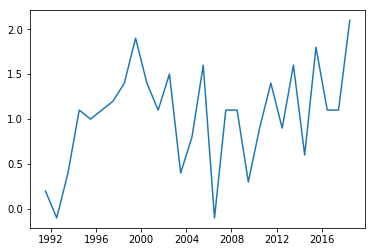

165 36023


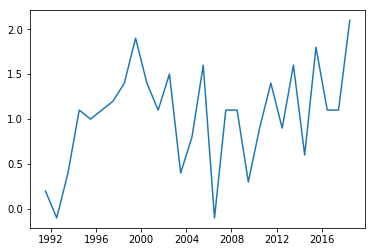

287 37145


In [40]:
f=lambda u:u/u[0]
for i in np.random.choice(range(len(dest.columns)),10):
    print i, dest.columns[i] 
    plt.plot(f(target.iloc[:,i]),alpha=0.5)
    plt.plot(f(src.loc[:,dest.columns[i][:2]]),alpha=0.5)
    plt.plot(f(dest.iloc[:,i]),alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(f(dest.iloc[:,i])/f(target.iloc[:,i])-1),1).dropna())
    plt.show()

In [41]:
dest.tail()

FIPS code        06001       06003       06005       06007       06009  \
Month                                                                    
2018-08-01  354.832454  176.363834  193.446832  227.346929  205.808430   
2018-09-01  354.222652  176.060741  193.114381  226.956219  205.454735   
2018-10-01  360.916469  179.387797  196.763702  231.245056  209.337255   
2018-11-01  362.273350  180.062213  197.503444  232.114432  210.124268   
2018-12-01  365.404395  181.618449  199.210420  234.120543  211.940323   

FIPS code        06011       06013       06015       06017       06019  \
Month                                                                    
2018-08-01  221.874222  282.103101  218.967715  234.690177  221.682160   
2018-09-01  221.492917  281.618289  218.591405  234.286846  221.301184   
2018-10-01  225.678513  286.940086  222.722171  238.714212  225.483157   
2018-11-01  226.526962  288.018851  223.559505  239.611669  226.330872   
2018-12-01  228.484782  290.508131  225.491678  241.682577  228.286997   

FIPS code      ...           39157       39159       39161       39163  \
Month          ...                                                       
2018-08-01     ...      191.979529  209.444461  171.050730  159.438941   
2018-09-01     ...      193.626831  211.241622  172.518450  160.807025   
2018-10-01     ...      195.572890  213.364719  174.252357  162.423226   
2018-11-01     ...      195.272564  213.037073  173.984773  162.173806   
2018-12-01     ...      195.284087  213.049644  173.995039  162.183375   

FIPS code        39165       39167       39169       39171       39173  \
Month                                                                    
2018-08-01  181.173780  207.399027  192.569388  159.554346  169.966805   
2018-09-01  182.728362  209.178638  194.221752  160.923420  171.425225   
2018-10-01  184.564885  211.281000  196.173790  162.540791  173.148145   
2018-11-01  184.281464  210.956554  195.872542  162.291190  172.882255   
2018-12-01  184.292338  210.969002  195.884100  162.300767  172.892457   

FIPS code        39175  
Month                   
2018-08-01  205.228846  
2018-09-01  206.989835  
2018-10-01  209.070200  
2018-11-01  208.749148  
2018-12-01  208.761466  

[5 rows x 402 columns]

In [42]:
dest.to_csv("../input/third2/HPI_at_county_monthly.csv")

# tract monthly

In [43]:
%reset -f

In [44]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [45]:
county_at_monthly=pd.read_csv("../input/third2/HPI_at_county_monthly.csv", parse_dates=['Month']).set_index('Month')
#state_po_monthly.columns=['36','39','19','37','06']

In [46]:
county_at_monthly.head()

06001       06003       06005       06007       06009  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.210000  100.210000  100.210000  100.210000  100.210000   
1991-03-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-04-01   99.574089   99.574089   99.574089   99.574089   99.574089   
1991-05-01   99.812685   99.812685   99.812685   99.812685   99.812685   

                 06011       06013       06015       06017       06019  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.210000  100.210000  100.210000  100.210000  100.210000   
1991-03-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-04-01   99.574089   99.574089   99.574089   99.574089   99.574089   
1991-05-01   99.812685   99.812685   99.812685   99.812685   99.812685   

               ...           39157       39159       39161       39163  \
Month          ...                                                       
1991-01-01     ...      100.000000  100.000000  100.000000  100.000000   
1991-02-01     ...      101.000000  101.000000  101.000000  101.000000   
1991-03-01     ...      101.350000  101.350000  101.350000  101.350000   
1991-04-01     ...      101.730924  101.730924  101.730924  101.730924   
1991-05-01     ...      102.350747  102.350747  102.350747  102.350747   

                 39165       39167       39169       39171       39173  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  101.000000  101.000000  101.000000  101.000000  101.000000   
1991-03-01  101.350000  101.350000  101.350000  101.350000  101.350000   
1991-04-01  101.730924  101.730924  101.730924  101.730924  101.730924   
1991-05-01  102.350747  102.350747  102.350747  102.350747  102.350747   

                 39175  
Month                   
1991-01-01  100.000000  
1991-02-01  101.000000  
1991-03-01  101.350000  
1991-04-01  101.730924  
1991-05-01  102.350747  

[5 rows x 402 columns]

In [47]:
assert county_at_monthly.isnull().sum().sum()==0

In [48]:
county_at_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [49]:
tract_at_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_tract_5state.csv", dtype={'tract':np.str}).set_index("tract").T
tract_at_hpi.index=pd.to_datetime(['{}-07-01'.format(u) for u in tract_at_hpi.index])

In [50]:
tract_at_hpi.index.max()

Timestamp('2018-07-01 00:00:00')

In [51]:
tract_at_hpi.tail()

tract       06001400100  06001400200  06001400300  06001400400  06001400500  \
2014-07-01   505.390000   613.440000  1063.230000  1152.970000   558.990000   
2015-07-01   588.020000   614.690000  1208.000000  1261.490000   594.150000   
2016-07-01   599.000000   672.390000  1270.690000  1411.290000   723.550000   
2017-07-01   649.139160   728.672300  1408.880000  1423.540000   815.530000   
2018-07-01   699.278364   784.954573  1547.070068  1435.790039   907.510071   

tract       06001400600  06001400700  06001400800  06001400900  06001401000  \
2014-07-01   352.580000   473.530000   442.390000   355.330000   385.590000   
2015-07-01   363.500000   541.260000   472.880000   440.980000   431.190000   
2016-07-01   416.560000   607.230000   601.430000   484.150000   515.700000   
2017-07-01   483.340000   707.400000   586.930000   545.370000   513.650000   
2018-07-01   550.119995   807.570068   572.429993   606.589996   511.600037   

tract          ...       39173022200  39173022300  39173022400  39173022500  \
2014-07-01     ...        133.890000   150.950000   142.150000   156.120000   
2015-07-01     ...        129.970000   146.380000   148.860000   170.530000   
2016-07-01     ...        156.690000   168.600000   151.890000   166.070000   
2017-07-01     ...        146.290000   163.490000   156.590000   187.060000   
2018-07-01     ...        135.889984   158.380005   161.289993   208.049988   

tract       39175938000  39175938100  39175938200  39175938300  39175938400  \
2014-07-01   118.040000   168.770000   102.690000   164.930000   172.690000   
2015-07-01   117.920000   173.320000   111.280000   169.380000   185.300000   
2016-07-01   133.910000   176.340000   117.530000   177.500000   185.500000   
2017-07-01   140.250000   210.100000   117.240000   177.640000   208.700000   
2018-07-01   146.589996   243.860016   116.949997   177.779999   231.899994   

tract       39175938500  
2014-07-01   143.870000  
2015-07-01   131.400000  
2016-07-01   133.330000  
2017-07-01   124.730000  
2018-07-01   116.130005  

[5 rows x 14412 columns]

In [52]:
src=county_at_monthly.sort_index()
target=tract_at_hpi.sort_index()

In [53]:
from dateutil.relativedelta import relativedelta

In [54]:
def make_year(yr):
    return pd.to_datetime(['{}-{}-01'.format(yr,m) for m in range(1,13)])

In [55]:
def make_src_ratio(src,yr):
    quarter_dts1=make_year(yr)
    quarter_dts2=make_year(yr-1)
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [56]:
make_year(target.index[0].year)

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01', '1991-11-01', '1991-12-01'],
              dtype='datetime64[ns]', freq=None)

In [57]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        dt=dt.year
        quarter_dts=make_year(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [58]:
len(target.columns)

14412

In [59]:
%%time 
dest=[]
for i, col in enumerate(target.columns[:]):
    if i%1000==0: print i,
    target_s=target[col]
    src_s=src[col[:5]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns[:len(dest)],index=src.index)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000CPU times: user 6min 59s, sys: 384 ms, total: 6min 59s
Wall time: 6min 59s



13479 39095006800


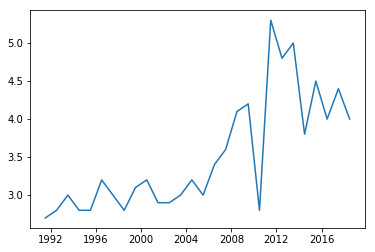

3561 06059099311


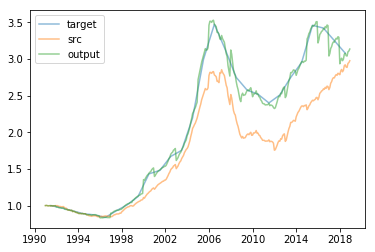

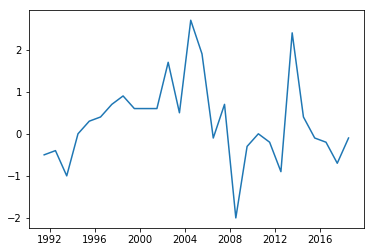

8914 36077590300


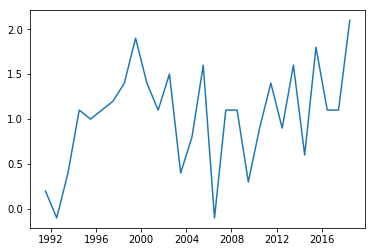

5060 06073015000


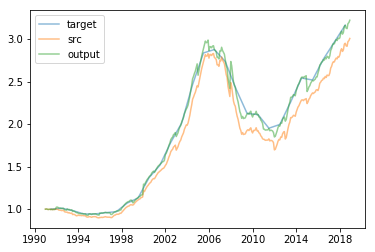

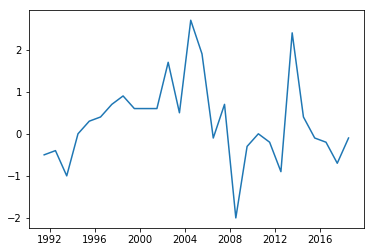

5292 06073020810


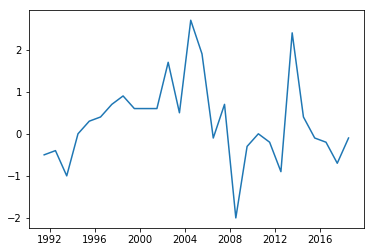

2608 06037650101


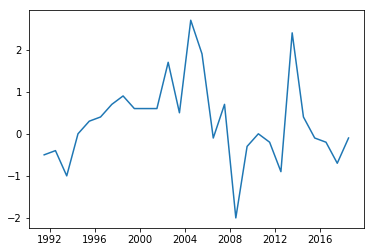

77 06001409400


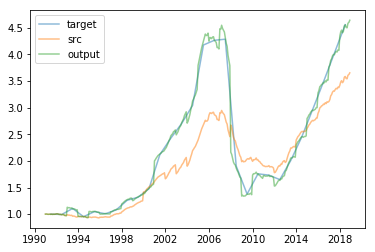

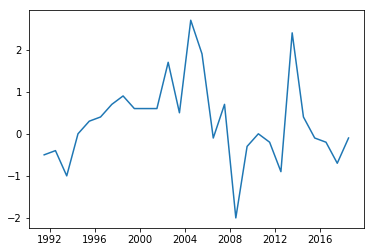

7842 36027110004


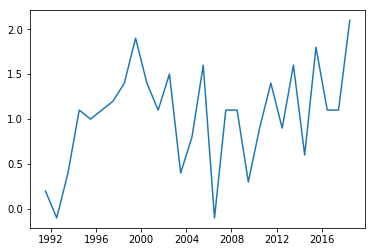

9050 36081056800


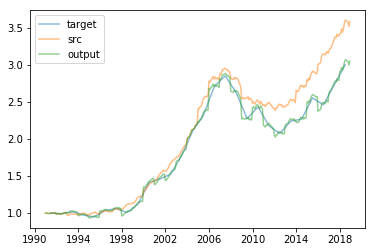

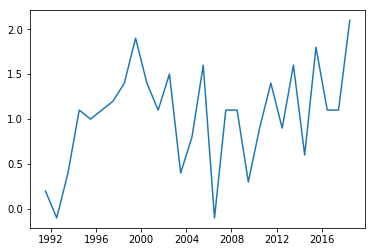

9648 36103146402


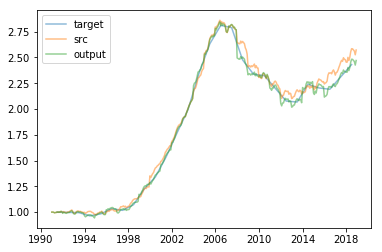

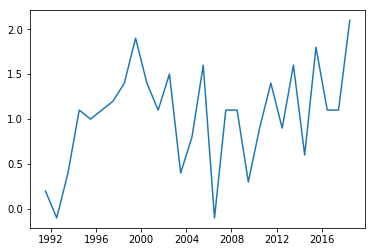

In [60]:
f=lambda u:u/u[0]
for i in np.random.choice(range(len(dest.columns)),10):
    print i, dest.columns[i] 
    plt.plot(f(target.iloc[:,i]),alpha=0.5)
    plt.plot(f(src.loc[:,dest.columns[i][:5]]),alpha=0.5)
    plt.plot(f(dest.iloc[:,i]),alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(f(dest.iloc[:,i])/f(target.iloc[:,i])-1),1).dropna())
    plt.show()

In [61]:
dest.tail()

tract       06001400100  06001400200  06001400300  06001400400  06001400500  \
Month                                                                         
2018-08-01   442.438454   449.585098   479.706732   469.166804   545.332199   
2018-09-01   441.678095   448.812457   478.882324   468.360510   544.395010   
2018-10-01   450.024575   457.293756   487.931860   477.211213   554.682552   
2018-11-01   451.716463   459.012973   489.766262   479.005310   556.767907   
2018-12-01   455.620543   462.980116   493.999198   483.145242   561.579922   

tract       06001400600  06001400700  06001400800  06001400900  06001401000  \
Month                                                                         
2018-08-01   543.990602   599.618702   562.017497   599.831419   505.899830   
2018-09-01   543.055719   598.588218   561.051633   598.800570   505.030408   
2018-10-01   553.317952   609.899861   571.653939   610.116225   514.574070   
2018-11-01   555.398177   612.192807   573.803098   612.409985   516.508634   
2018-12-01   560.198354   617.483847   578.762345   617.702902   520.972698   

tract          ...       39173022200  39173022300  39173022400  39173022500  \
Month          ...                                                            
2018-08-01     ...        143.741962   167.531498   170.609631   220.071506   
2018-09-01     ...        144.975356   168.969021   172.073566   221.959854   
2018-10-01     ...        146.432440   170.667255   173.803002   224.190675   
2018-11-01     ...        146.207576   170.405175   173.536108   223.846404   
2018-12-01     ...        146.216203   170.415231   173.546348   223.859613   

tract       39175938000  39175938100  39175938200  39175938300  39175938400  \
Month                                                                         
2018-08-01   203.893806   255.974415   195.255652   186.611696   243.420247   
2018-09-01   205.643340   258.170832   196.931065   188.212939   245.508941   
2018-10-01   207.710171   260.765594   198.910333   190.104584   247.976444   
2018-11-01   207.391208   260.365158   198.604883   189.812657   247.595647   
2018-12-01   207.403446   260.380522   198.616602   189.823857   247.610258   

tract       39175938500  
Month                    
2018-08-01   161.526634  
2018-09-01   162.912632  
2018-10-01   164.549995  
2018-11-01   164.297309  
2018-12-01   164.307004  

[5 rows x 14412 columns]

In [62]:
dest.to_csv("../input/third2/HPI_at_tract_monthly.csv",float_format="%.2f")